In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Listing

In [ ]:
cols = [
    'id', 'host_id', 'neighbourhood_cleansed',
    'latitude', 'longitude', 'room_type', 'accommodates',
    'price', 'minimum_nights', 'number_of_reviews', 'review_scores_rating',
    'last_review', 'reviews_per_month', 'calculated_host_listings_count',
    'calculated_host_listings_count_entire_homes', 'calculated_host_listings_count_private_rooms',
    'calculated_host_listings_count_shared_rooms', 'host_listings_count', 'host_is_superhost',
    'amenities', 'last_scraped', 'license', 'availability_365'
]

df = pd.read_csv('./airbnb_data/listings_truncated/2024-12-07_listings.csv', usecols=cols, low_memory=False)
listings = df.copy()

In [116]:
listings.head()

,id,host_id,neighbourhood_cleansed,latitude,longitude,room_type,accommodates,price,minimum_nights,number_of_reviews,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_listings_count,host_is_superhost,amenities,last_scraped,license,availability_365
0,22466407,164674166,Castello,45.436460,12.349550,Entire home/apt,2,NaN,3,36,...,1,1,0,0,1,f,"[""Bed linens"", ""Wifi"", ""Kitchen"", ""Heating"", ""...",2024-12-07,NaN,0
1,705804689669784695,48092742,San Marco,45.434790,12.338250,Entire home/apt,4,NaN,2,0,...,46,24,22,0,46,f,"[""Kitchen""]",2024-12-07,NaN,0
2,736250094898977332,48092742,Castello,45.437230,12.338060,Private room,2,NaN,1,0,...,46,24,22,0,46,f,"[""Wifi"", ""Kitchen"", ""Fire extinguisher"", ""Air ...",2024-12-07,NaN,0
3,1205316153186347356,12355491,San Polo,45.439419,12.334532,Private room,1,NaN,2,14,...,6,0,4,0,6,t,"[""Bed linens"", ""Kitchenette"", ""Bidet"", ""Indesi...",2024-12-07,NaN,0
4,1209138608237195335,311957953,San Marco,45.434620,12.330060,Entire home/apt,3,$109.00,1,2,...,12,12,0,0,12,t,"[""Wifi"", ""Washer"", ""Kitchen"", ""Air conditionin...",2024-12-07,IT027042B4ZE3VF2NF,340


In [117]:
listings.isnull().sum()

id                                                 0
host_id                                            0
neighbourhood_cleansed                             0
latitude                                           0
longitude                                          0
room_type                                          0
accommodates                                       0
price                                            875
minimum_nights                                     0
number_of_reviews                                  0
review_scores_rating                             648
last_review                                      648
reviews_per_month                                648
calculated_host_listings_count                     0
calculated_host_listings_count_entire_homes        0
calculated_host_listings_count_private_rooms       0
calculated_host_listings_count_shared_rooms        0
host_listings_count                                0
host_is_superhost                             

In [118]:
# Clean price
listings['price'] = listings['price'].replace('[\$,]', '', regex=True).astype(float)

# Clean superhost flag
listings['host_is_superhost'] = listings['host_is_superhost'].fillna('f')

# Fill missing reviews info
listings['reviews_per_month'] = listings['reviews_per_month'].fillna(0)
listings['number_of_reviews'] = listings['number_of_reviews'].fillna(0)

# Replace NaN in rating (optional: set 0 or median)
listings['review_scores_rating'] = listings['review_scores_rating'].fillna(listings['review_scores_rating'].median())

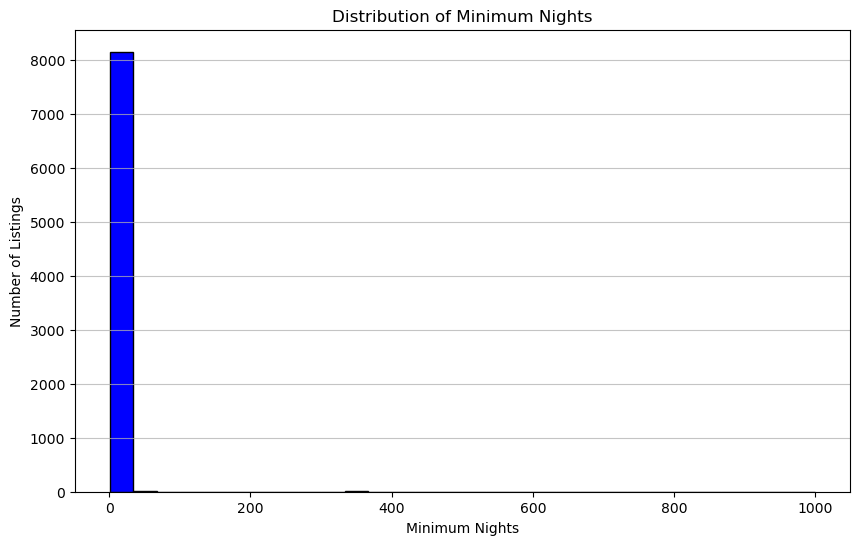

In [119]:
# Plot histogram of minimum nights
plt.figure(figsize=(10, 6))
plt.hist(listings['minimum_nights'].dropna(), bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Minimum Nights')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Listings')
plt.grid(axis='y', alpha=0.75)
plt.show()

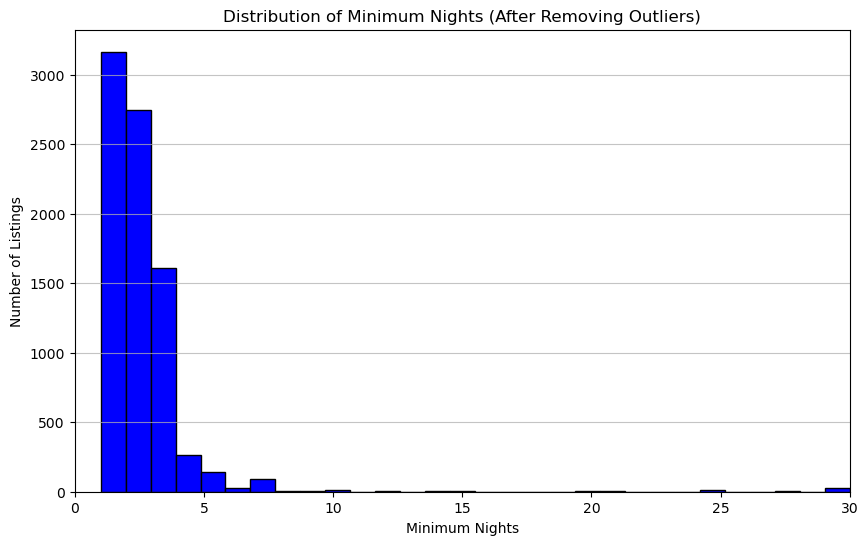

In [120]:
# Remove extreme outliers (minimum_nights over 99 percentile)
min_nights_threshold = 30 # common Airbnb minimum nights for short-term rentals
min_nights_covered = listings[listings['minimum_nights'] <= min_nights_threshold]
plt.figure(figsize=(10, 6))
plt.hist(min_nights_covered['minimum_nights'].dropna(), bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Minimum Nights (After Removing Outliers)')
plt.xlabel('Minimum Nights')
plt.ylabel('Number of Listings')
plt.xlim(0, min_nights_threshold)  # Limit x-axis to focus on lower prices
plt.grid(axis='y', alpha=0.75)
plt.show()

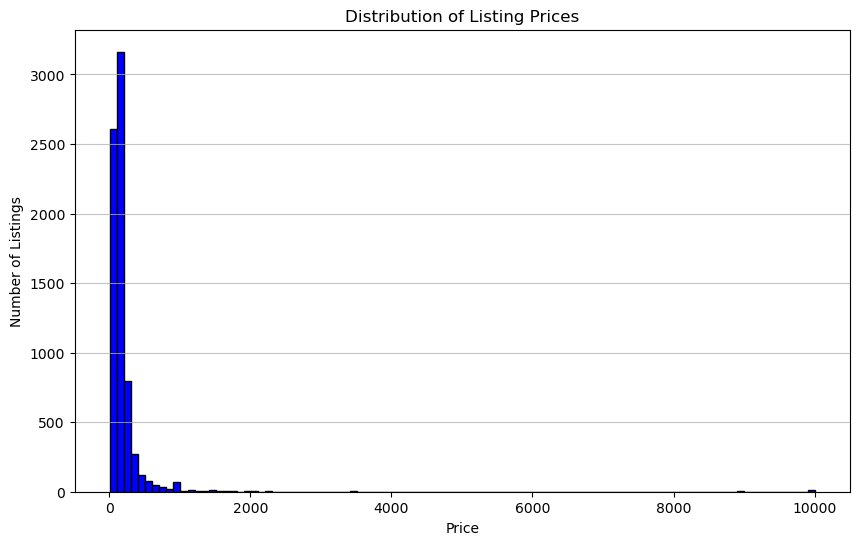

In [121]:
# Plot histogram of price distribution
plt.figure(figsize=(10, 6))
plt.hist(listings['price'].dropna(), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Listing Prices')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.grid(axis='y', alpha=0.75)
plt.show()

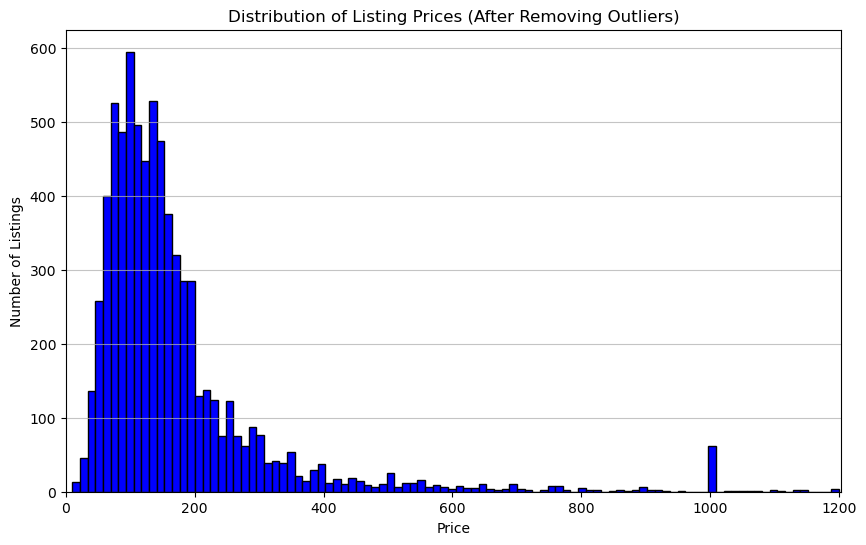

In [122]:
# Remove extreme outliers (prices above 99 percentile)
price_threshold = listings['price'].quantile(0.99)
price_covered = listings[listings['price'] <= price_threshold]
plt.figure(figsize=(10, 6))
plt.hist(price_covered['price'].dropna(), bins=100, color='blue', edgecolor='black')
plt.title('Distribution of Listing Prices (After Removing Outliers)')
plt.xlabel('Price')
plt.ylabel('Number of Listings')
plt.xlim(0, price_threshold)  # Limit x-axis to focus on lower prices
plt.grid(axis='y', alpha=0.75)
plt.show()

In [123]:
# Then should remove outliers in further analysis
listings = listings[listings['minimum_nights'] <= min_nights_threshold]
listings = listings[listings['price'] <= price_threshold]

In [128]:
# Total removed listings
print(f"Total listings before outlier removal: {len(df)}")
print(f"Total listings after outlier removal: {len(listings)}")
print(f"Total listings removed: {len(df) - len(listings)}")

Total listings before outlier removal: 8163
Total listings after outlier removal: 7179
Total listings removed: 984


In [129]:
listings.describe()

,id,host_id,latitude,longitude,accommodates,price,minimum_nights,number_of_reviews,review_scores_rating,reviews_per_month,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,host_listings_count,availability_365,multi_host_flag,price_per_accommodate
count,7.179000e+03,7.179000e+03,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000,7179.000000
mean,4.103023e+17,1.939767e+08,45.446079,12.319045,3.769327,170.446302,2.125644,101.887310,4.730536,2.029953,12.550216,11.067976,1.415935,0.018805,18.901379,236.407020,0.702187,50.306655
std,4.993344e+17,2.002695e+08,0.023541,0.040471,1.802525,146.265919,1.971964,136.325252,0.336609,2.134363,25.570293,24.761934,3.231782,0.322479,51.089141,108.620454,0.457329,51.891257
min,6.623000e+03,1.501600e+04,45.272554,12.184216,1.000000,10.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.600000
25%,2.085570e+07,1.763260e+07,45.434381,12.322507,2.000000,91.000000,1.000000,11.000000,4.670000,0.510000,1.000000,1.000000,0.000000,0.000000,2.000000,161.000000,0.000000,27.500000
50%,4.615375e+07,1.137036e+08,45.438420,12.331070,4.000000,133.000000,2.000000,49.000000,4.810000,1.470000,3.000000,2.000000,0.000000,0.000000,4.000000,266.000000,1.000000,39.166667
75%,9.240906e+17,3.645291e+08,45.445221,12.340030,4.000000,189.000000,3.000000,143.000000,4.920000,2.940000,9.000000,7.000000,1.000000,0.000000,11.000000,330.000000,1.000000,57.500000
max,1.304842e+18,6.638828e+08,45.536750,12.420600,16.000000,1200.000000,30.000000,2795.000000,5.000000,52.240000,133.000000,133.000000,17.000000,7.000000,1279.000000,365.000000,1.000000,1000.000000


In [124]:
# Some feature engineering can be done here
listings['multi_host_flag'] = (listings['calculated_host_listings_count'] > 1).astype(int)
listings['price_per_accommodate'] = listings['price'] / listings['accommodates']

In [125]:
agg = listings.groupby('neighbourhood_cleansed').agg(
    n_listings=('id', 'count'),
    avg_price=('price', 'mean'),
    median_price=('price', 'median'),
    avg_price_per_person=('price_per_accommodate', 'mean'),
    pct_entire_home=('room_type', lambda x: (x=='Entire home/apt').mean()*100),
    pct_superhost=('host_is_superhost', lambda x: (x=='t').mean()*100),
    avg_availability=('availability_365', 'mean'),
    avg_rating=('review_scores_rating', 'mean'),
    avg_reviews=('number_of_reviews', 'mean'),
    avg_min_nights=('minimum_nights', 'mean'),
    pct_multi_host=('multi_host_flag', 'mean')
).reset_index()
agg['snapshot_date'] = '2025-03'

In [126]:
agg

,neighbourhood_cleansed,n_listings,avg_price,median_price,avg_price_per_person,pct_entire_home,pct_superhost,avg_availability,avg_rating,avg_reviews,avg_min_nights,pct_multi_host,snapshot_date
0,Aeroporto,10,103.700000,111.0,43.533333,10.000000,0.000000,315.700000,4.758000,77.800000,1.000000,0.800000,2025-03
1,Alberoni,14,170.714286,121.5,37.851190,85.714286,35.714286,246.142857,4.518571,12.571429,2.571429,0.285714,2025-03
2,Altobello,19,83.631579,77.0,25.758772,73.684211,57.894737,171.421053,4.862632,208.421053,1.947368,0.736842,2025-03
3,Bissuola,48,83.541667,72.0,23.326620,75.000000,39.583333,219.083333,4.774167,81.333333,1.854167,0.395833,2025-03
4,Burano,30,171.733333,140.5,46.119246,86.666667,63.333333,253.933333,4.906000,43.533333,1.966667,0.466667,2025-03
5,Ca' Brentelle,1,132.000000,132.0,22.000000,100.000000,0.000000,347.000000,5.000000,6.000000,1.000000,0.000000,2025-03
6,Ca' Emiliani,1,45.000000,45.0,11.250000,0.000000,0.000000,264.000000,4.730000,85.000000,1.000000,0.000000,2025-03
7,Campalto,31,102.709677,80.0,40.597926,29.032258,12.903226,292.129032,4.412581,38.516129,1.193548,0.677419,2025-03
8,Campalto Bagaron,8,196.750000,196.0,73.585417,75.000000,75.000000,251.625000,4.847500,70.250000,1.875000,1.000000,2025-03
9,Campalto CEP,6,75.666667,58.0,23.753968,33.333333,0.000000,269.166667,4.313333,32.833333,1.000000,0.833333,2025-03


### Calendar

In [131]:
df = pd.read_csv('./airbnb_data/calendar_truncated/2024-12-07_calendar.csv', low_memory=False)

df.head()

,listing_id,date,available,price
0,6623,2024-12-07,f,$290.00
1,6623,2024-12-08,f,$290.00
2,6623,2024-12-09,f,$290.00
3,6623,2024-12-10,f,$290.00
4,6623,2024-12-11,f,$290.00


In [132]:
# Great, sign of safely aggregating data
df.isnull().sum()

listing_id    0
date          0
available     0
price         0
dtype: int64